# Variational Autoencoders
#### [Auto-Encoding Variational Bayes - Kingma and Welling, 2013](https://arxiv.org/abs/1312.6114)
Efficient inference and learning in a directed probabilistic model, in the presence of latent variables with an intractable posterior distribution over large datasets.

Use this code with no warranty and please respect the accompanying license.

In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
sys.path.append('../')
sys.path.append('../common')
sys.path.append('../GenerativeModels')

from tools_general import tf, np
from IPython.display import Image
from tools_train import get_train_params, OneHot, vis_square
from tools_config import data_dir
from tools_train import get_train_params, plot_latent_variable
import matplotlib.pyplot as plt
import imageio
from tensorflow.examples.tutorials.mnist import input_data
from tools_train import get_demo_data

In [2]:
# define parameters
networktype = 'VAE_MNIST'

work_dir = '../trained_models/%s/' %networktype
if not os.path.exists(work_dir): os.makedirs(work_dir)

## Network definitions

In [3]:
from VAE import create_encoder, create_decoder, create_vae_trainer

# Training VAE
You can either get the fully trained models from the [google drive](https://goo.gl/7PrKD2) or train your own models using the VAE.py script.

## Evolution of the latent variable during the training phase
Evolution of approximate posterior Q(z|X) and likelihood P(X|z) during training with 2D latent space.

In [5]:
#Image(url=work_dir+'posterior_likelihood_evolution.gif') 

Visualization of the 2D latent variable corresponding to a Convolutional Variational Autoencoder during training on MNIST dataset (handwritten digits). The image to the left is the mean of the approximate posterior Q(z|X) and each color represents a class of digits within the dataset. The image to the left shows samples from the decoder (likelihood) P(X|z). The title above shows the iteration number and total loss [Reconstruction + KL] of the model at the point that images below were produced from the model under training. One can observe that by the time the generated outputs (left image) get better, the points on the latent space (posterior) also get into better seperated clusters. Also note that points get closer to each other because the KL part of the total loss is imposing a zero mean gaussian distribution on the latent variable, which is realized on the latent variable as the trainig proceeds.

# Experiments
Create demo networks and restore weights

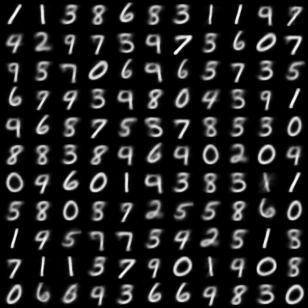

In [11]:
iter_num = 37752
best_model = work_dir + "Model_Iter_%.3d.ckpt"%iter_num
best_img = work_dir + 'Rec_Iter_%d.jpg'%iter_num
Image(filename=best_img)

In [22]:
latentD = 2
batch_size = 128

tf.reset_default_graph() 
demo_sess = tf.InteractiveSession()

is_training = tf.placeholder(tf.bool, [], 'is_training')

Zph = tf.placeholder(tf.float32, [None, latentD])
Xph = tf.placeholder(tf.float32, [None, 28, 28, 1])

z_mu_op, z_log_sigma_sq_op = create_encoder(Xph, is_training, latentD, reuse=False, networktype=networktype + '_Enc') 
Z_op = tf.add(z_mu_op, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq_op)), Zph))
Xrec_op = create_decoder(Z_op, is_training, latentD, reuse=False, networktype=networktype + '_Dec')
Xgen_op = create_decoder(Zph, is_training, latentD, reuse=True, networktype=networktype + '_Dec')
    
tf.global_variables_initializer().run()

Enc_varlist = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_Enc')    
Dec_varlist = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=networktype + '_Dec')
print('List of vars in Encoder:%d -- %s\n' % (len(Enc_varlist), '; '.join([var.name.split('/')[1] for var in Enc_varlist])))
print('List of vars in Decoder:%d -- %s\n' % (len(Dec_varlist), '; '.join([var.name.split('/')[1] for var in Dec_varlist])))

saver = tf.train.Saver(var_list=Enc_varlist+Dec_varlist)
saver.restore(demo_sess, best_model)

List of vars in Encoder:12 -- conv1_W:0; conv1_BN_beta:0; conv1_BN_scale:0; conv1_BN_pop_mean:0; conv1_BN_pop_var:0; conv2_W:0; conv2_BN_beta:0; conv2_BN_scale:0; conv2_BN_pop_mean:0; conv2_BN_pop_var:0; dense_mean_W:0; dense_var_W:0

List of vars in Decoder:11 -- dense1_W:0; dense1_BN_beta:0; dense1_BN_scale:0; dense1_BN_pop_mean:0; dense1_BN_pop_var:0; deconv1_W:0; deconv1_BN_beta:0; deconv1_BN_scale:0; deconv1_BN_pop_mean:0; deconv1_BN_pop_var:0; deconv2_W:0



Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


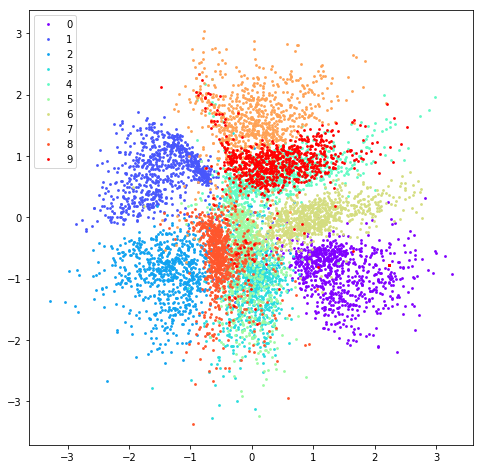

In [19]:
#Get uniform samples over the labels
spl = 800  # sample_per_label
data = input_data.read_data_sets(data_dir, one_hot=False, reshape=False)
Xdemo, Xdemo_labels = get_demo_data(data, spl)

decoded_data = demo_sess.run(z_mu_op, feed_dict={Xph:Xdemo, is_training:False})
plot_latent_variable(decoded_data, Xdemo_labels)

### Generate new data
Generate samples from the approximate posterior distribution over the latent variables p(z|x)

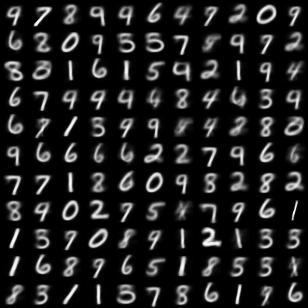

In [26]:
Zdemo = np.random.normal(size=[128, latentD], loc=0.0, scale=1.).astype(np.float32)

gen_sample = demo_sess.run(Xgen_op, feed_dict={Zph: Zdemo , is_training:False})
vis_square(gen_sample[:121], [11, 11], save_path=work_dir + 'sample.jpg')
Image(filename=work_dir + 'sample.jpg')

Take a look at [Semi-Supervised Learning with Deep Generative Models](https://arxiv.org/abs/1406.5298).